<a href="https://colab.research.google.com/github/pam1202g/Notes_on_AI/blob/main/_notebooks/2020-05-23-text-generation-with-blurr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summarization with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new summarization capabilities to train, evaluate, and deploy a BART summarization model.

*Updated on 08/21/2020 to use fastai 2.0.0 and also demo batch-time padding*.  
*Updated on 09/25/2020 to use on the fly batch-time tokenization*.  
*Updated on 11/12/2020 with support for fastai >= 2.1.5 and mixed precision*. 
*Updated on 12/31/2020 (too much for one sentence, see the docs for more).*  
*Updated on 05/13/2022 (using blurr 1.0.x)*
- toc: false 
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, summarization, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [2]:
# only run this cell if you are in collab
!pip install transformers -Uqq
!pip install datasets -Uqq
!pip install bert-score -Uqq
!pip install sacremoses
!pip install ohmeow-blurr -Uqq

     |████████████████████████████████| 5.3 MB 34.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.0 MB/s 
     |████████████████████████████████| 163 kB 75.3 MB/s 
     |████████████████████████████████| 441 kB 19.7 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 115 kB 64.4 MB/s 
     |████████████████████████████████| 127 kB 66.8 MB/s 
     |████████████████████████████████| 115 kB 63.3 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 32.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=7ecb412c7a3aca50d55754a27a5daf0b513a676eac6b8a65779f4acf3838e2f0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
     |████████████████████

In [3]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

import nltk
nltk.download('punkt', quiet=True)

/usr/local/lib/python3.7/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


True

## Data Preparation

We're going to use to use the  [datasets](https://huggingface.co/datasets) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [4]:
raw_data = datasets.load_dataset('cnn_dailymail', '3.0.0', split='train[:1%]')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


In [5]:
df = pd.DataFrame(raw_data)
df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something simila...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund .,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the son of the president""\nLeifman says the system is unjust and he's fighting for change .",ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just completely gave way, fell all the way down,"" survivor Gary Babineau told CNN. ""I probably had a 30-, 35-foot free fall. And there's cars in the water, there's cars on fire. The whole bridge is down."" He said his back was injured but he determined he could move around. ""I realized there was a school bus right next to me, and me and a couple of other guys went over and started lifting the kids off t...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collapsed during rush hour Wednesday .",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the National Naval Medical Center in Bethesda, Maryland, for routine microscopic examination, spokesman Scott Stanzel said. Results are expected in two to three days. All were small, less than a centimeter [half an inch] in diameter, he said. Bush is in good humor, Stanzel said, and will resume his activities at Camp David. During the procedure Vice President Dick Cheney assumed presidential power. Bu...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David .",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appear in court Monday. A judge will have the final say on a plea deal. Earlier, Vick admitted to participating in a dogfighting ring as part of a plea agreement with federal prosecutors in Virginia. ""Your admitted conduct was not only illegal, but a

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [6]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization.  All we need is to define a single `Seq2SeqBatchTokenizeTransform` instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences.  In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with the latest release of blurr, we can even customize the text generation by passing in `text_gen_kwargs`.

We pass `noop` as a type transform for our targets because everything is already handled by the batch transform now.

In [12]:
hf_model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [7]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'max_length': 142,
 'min_length': 56,
 'do_sample': False,
 'early_stopping': True,
 'num_beams': 4,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'bad_words_ids': None,
 'bos_token_id': 0,
 'pad_token_id': 1,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'no_repeat_ngram_size': 3,
 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1,
 'decoder_start_token_id': 2,
 'use_cache': True,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None,
 'suppress_tokens': None,
 'begin_suppress_tokens': None}

In [8]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('article'), get_y=ColReader('highlights'), splitter=RandomSplitter())

In [9]:
dls = dblock.dataloaders(df, bs=2)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [10]:
len(dls.train.items), len(dls.valid.items)

(2297, 574)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [11]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 51]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.  We pass in the `dls` via the `dataloaders` argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [13]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> You wanted to know more about greenwashing, and Scot Case, from environmental marketing firm TerraChoice, answered. Greenwashing expert Scot Case of TerraChoice. ""Why are green products often more expensive than ones that don't say they are green or environmentally friendly? Is it just because green has become a new form of 'premium brand'? Isn't this bad news if we want to make more people environmentally aware when they go shopping?"" Harriet Gladwell. Case: First, it should be noted that not all greener products are more expensive. The remanufactured toner cartridges I purchase at a nationwide office-supply store, for example, carry the same warranty as other cartridges at a 30-percent lower cost. This greener option is less expensive because the manufacturer avoids the cost of manufacturing the plastic and electronic components. They simply reuse the parts from recycled cartridges. There are also greener products that do not cost extra. There are cleaning products and paints, for example, that have been certified as meeting tough environmental standards by EcoLogo or Green Seal that deliver the same high-quality performance one expects without costing any extra. Other greener products might be slightly more expensive initially, but generate substantial savings for the consumer. Energy-efficient compact fluorescent lightbul</s>","Scot Case answers your questions on greenwashing.\nHas green become a new form of ""premium brand""?\nWhat green words and phrases should raise a red flag?\nClick here to read more answers to your questions."
1,"<s> (CNN) -- Donna Zovko will have to wait to travel to Falluja to see where her son died in one of the Iraq war's most infamous attacks. Clockwise from upper left: Wesley Batalona, Mike Teague, Scott Helvenston, Jerry Zovko. ""My dream was to go for the fifth anniversary, and that didn't come true,"" Zovko said this week while visiting friends in Boston, Massachusetts. ""It's not that I'm afraid for me. But people with me on the trip would be in more danger."" Tuesday marks five years since her son Jerry Zovko and three other civilian employees of the Blackwater private security firm were ambushed in Falluja on March 31, 2004. Gunmen attacked vehicles holding Zovko, Mike Teague, Wesley Batalona and Scott Helvenston and set the vehicles on fire. Shocking images beamed around the world showed Iraqis celebrating in front of charred bodies strung up on a bridge over the Euphrates River. The remains were dragged through the streets. Donna Zovko honors her son ». ""I didn't realize until way after the incident that he had been decapitated,"" said Helvenston's mother, Katy Helven</s>","It's been five years since killings of four U.S. contractors in Falluja.\nVictim's mom: ""I want Blackwater exposed and out of business""\nBlackwater, renamed Xe, says it ""continues to mourn"" the loss of the four men.\nAnother mom: Both sides are losers in Blackwater suit."


## Training

We'll prepare our BART model for training by wrapping it in blurr's `BaseModelWrapper` object and using the callback, `BaseModelCallback`, as usual.  A new `Seq2SeqMetricsCallback` object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with ALOT of other Seq2Seq models; see the docs for more information.

In [14]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [15]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


SuggestedLRs(valley=0.00015848931798245758)

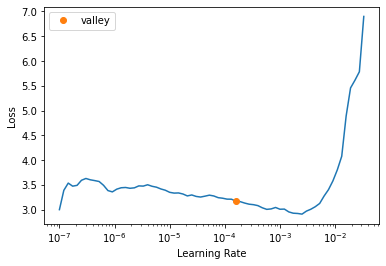

In [16]:
learn.lr_find()

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [17]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


(3,
 tensor(3.5603, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([2, 78, 50264]))

In [18]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.690788,1.666931,0.397533,0.174071,0.269591,0.880799,0.898242,0.889367,17:43


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

And now we can look at the generated predictions using our `text_gen_kwargs` above

In [19]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"LONDON, England (CNN) -- They first met in the autumn of 1979; she playing the role of the lovelorn terrorist, he dressed as a rather sloppy Ayatollah Khomeini. Pamela Stephenson first met Billy Connolly on the set of a comedy show in 1979. They married in Fiji in 1990. It may not have been love at first sight on the set of British comedy show ""Not the Nine O'Clock News,"" but love, marriage and children eventually followed. Australian comedienne, now psychotherapist, Pamela Stephenson, describes being captivated by Billy Connolly's wildman looks, his mane of grey hair and devil-may-care demeanor. She tells CNN's Revealed about her first impressions of her husband, his unique ability to keep audiences entertained and what she learnt about his addictions and childhood abuse while writing his best-selling biography, ""Billy."" CNN: Take us back to the beginning. How did you meet Billy Connolly? Pamela Stephenson: I'm not quite sure what Billy's version of how we met is like because he was very drunk. I met him when I was a performer on ""Not The Nine O'Clock News"" and he was a guest. He was just shaggy and some","Pamela Stephenson talks about marriage to Scottish comedian Billy Connelly.\nThey met on the set of British comedy show ""Not the Nine O'Clock News""\nShe says writing his biography, ""Billy,"" helped her understand him better.\nStephenson: ""It's like he's got these comedy angels whispering in his ear""","[ Pamela Stephenson first met Billy Connolly on the set of a British comedy show in 1979 .\nThey married in Fiji in 1990 and have three children together .\nShe tells CNN's Revealed about her husband's wildman looks, mane of grey hair and devil-may-care demeanor .\nPsychotherapist says she learned about his addictions and childhood abuse while writing biography ., World-renowned security expert Gavin de Becker says this weapon exists, but you already have it .\nOne chapter in Gavin's book ""The Gift of Fear"" has stuck with Oprah since she first read it. Gavin says that unlike any other living creature, humans will sense danger yet still walk right into it .]"


Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [20]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline 
crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

We can override the `text_gen_kwargs` we specified for our `DataLoaders` when we generate text using blurr's `Learner.blurr_generate` method

In [21]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1301: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 142 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


=== Prediction 1 ===
{'summary_texts': [' 2014 has been worst year for aviation fatalities so far this decade - with 1,158 deaths .\nTwo incidents involving Malaysia Airlines planes led to the deaths of 537 people .\nTotal death count of 1,212, including those presumed dead on board missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 .\nThe total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 .', ' 2014 has been worst year for aviation fatalities so far this decade - with 1,158 deaths .\nTwo incidents involving Malaysia Airlines planes led to the deaths of 537 people .\nTotal death count of 1,212, including those presumed dead on board missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 .\nBut total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 .', ' 2014 has been worst year for aviation fatalities so far this d

What about inference?  Easy!

In [22]:
learn.metrics = None
learn.export(fname='ft_cnndm_export.pkl')

In [23]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.blurr_summarize(test_article)

[{'summary_texts': ' 2014 has been worst year for aviation fatalities so far this decade - with 1,158 deaths .\nTwo incidents involving Malaysia Airlines planes led to the deaths of 537 people .\nTotal death count of 1,212, including those presumed dead on board missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 .\nThe total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 .'}]

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to summarization (e.g., sequence classification , token classification, and question/answering, causal language modeling, and transation). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!